# Heart Disease Classifier – Final Project

In [7]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


## 1. Data Loading & Cleaning

Our dataset (https://archive.ics.uci.edu/dataset/45/heart+disease) have 14 features, two of which (ca and thal) have missing values. We checked the dataset and found that 6 rows contain missing values. From here we have two main options to make the dataset usable.

1. **Exclude the 6 incomplete rows:** This is simple and safe. The dataset contains 303 rows, so removing 6 will reduce the size to roughly 98% which most likely wont affect the performance a lot. However, this solution assumes that the missing data have no correlation to the other values.
2. **Fill the missing data using the mean or mode:** For numerical features (like ca), the mean can be used. And for categorical features (like thal), the mode can be used
3. **Predict the missing values:** We could also try to predict the values using regression or KNN

**Our choice:** We choose the first option since it keeps the cleaning process simple and avoids inacurrate assumptions that could affect our results.P

In [8]:
# Load the data
df = pd.read_csv("./heart+disease/processed.cleveland.data", header=None, na_values="?")

# Add column names (from the 14 features)
df.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

# Check for missing values
print(df.isna().sum())

# Drop all the rows that are incomplete
df_clean = df.dropna()

print(f"Original size: {len(df)} rows")
print(f"After dropping missing: {len(df_clean)} rows")
# 6 rows dropped. Seems to check out!

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
Original size: 303 rows
After dropping missing: 297 rows


## 2. Exploratory Data Analysis (EDA)

First, we'll take a look at all the features to see what are numerical and what are categorical. The infromation for the data set says that all of the values are transfered to numerical which is good! But for the PCA and GMM in 3.

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  num  
0    3.0  0.0   6.0    0  
1    2.0  3.0   3.0    2  
2    2.0  2.0   7.0    1  
3    3.0  0.0   3.0    0  
4    1.0  0.0   3.0    0  
age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object


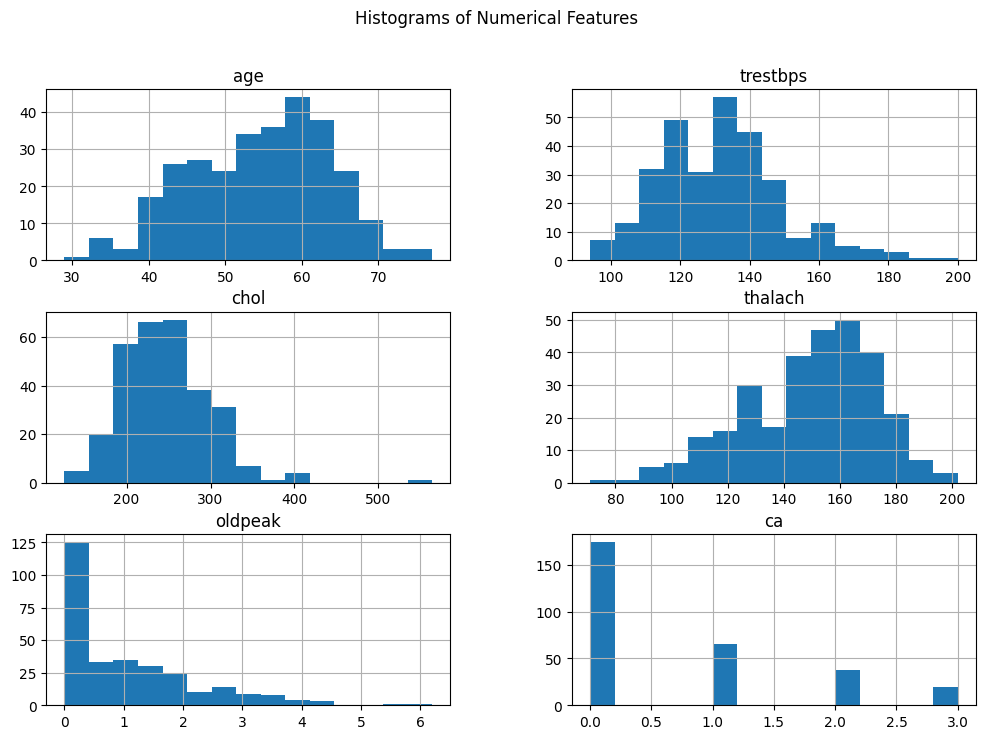

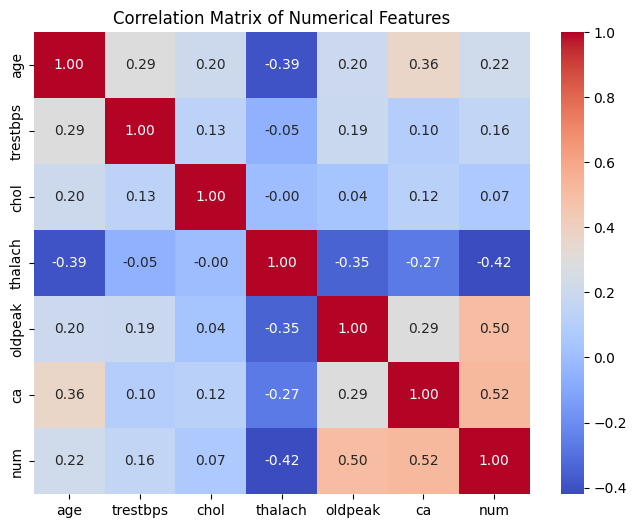

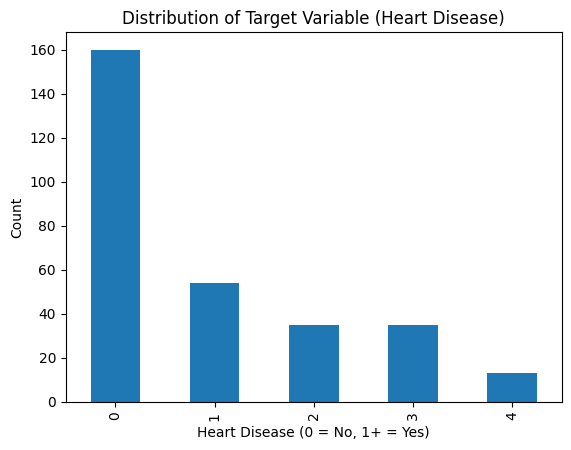

In [9]:
# Preview the first few rows
print(df_clean.head())

# Check data types
print(df_clean.dtypes)

# All the numerical features
numerical_features = [ "age", "trestbps", "chol", "thalach", "oldpeak", "ca", "num" ]
X_numerical = df_clean[numerical_features]
X_unsupervised = X_numerical.drop(columns="num")

# We dont want the labeldata for the unsupervised learning.
X_unsupervised.hist(bins=15, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(X_numerical.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

df_clean["num"].value_counts().plot(kind="bar")
plt.title("Distribution of Target Variable (Heart Disease)")
plt.xlabel("Heart Disease (0 = No, 1+ = Yes)")
plt.ylabel("Count")
plt.show()

## 3. Unsupervised Learning: PCA + GMM

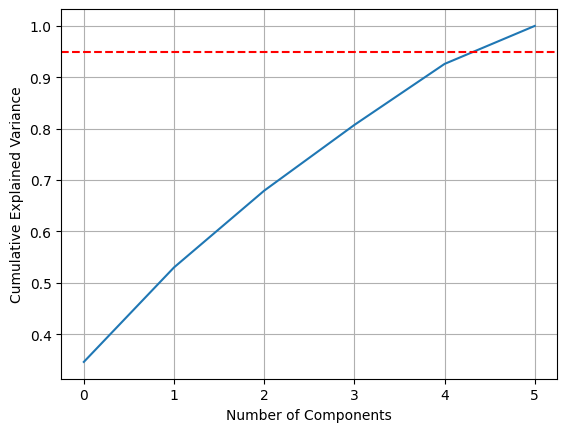

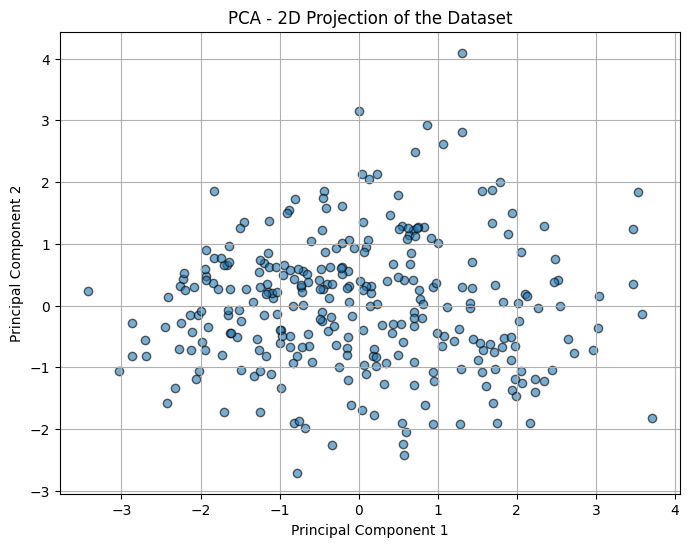

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsupervised)

pca = PCA().fit(X_scaled)  # Fit PCA without limiting components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
# plt.axhline(y=0.95, color='r', linestyle='--')  # Common threshold (e.g., 95%)
plt.grid()
plt.show()

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - 2D Projection of the Dataset")
plt.grid(True)
plt.show()

## 4. Supervised Learning: SVM, Random Forest, KNN

## 5. Feature Selection & Feature Importance

## 6. Evaluation: Accuracy, F1, Confusion Matrix


## 7. Conclusions & Discussion